In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.04

A=15
B=15
C=-48.78

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/365 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [4]:
def R0_sir(a, b2, gamma):
    return abs((a * b2) / gamma)
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu):
    return abs(((a** 2 * b1 * b2 * b3) / (b3 * gamma * mu + gamma * l * mu + gamma * mu** 2))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [5]:
def calculate_initial_values(R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_linha)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full, a0

In [6]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [7]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.7915786450042152 
R0_sei = 1.0732299265703247
R0_acoplado = 0.9217081376729355
Taxa de picadas = 0.02409676240499894


In [8]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, 0.06, 0.1, gamma)

In [9]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.8795318277824614 
R0_sei = 1.609844889855487
R0_acoplado = 1.1899200890903774
Taxa de picadas = 0.02409676240499894


In [10]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, 0.06, 0.12, gamma)

In [11]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.0554381933389536 
R0_sei = 1.609844889855487
R0_acoplado = 1.3034921488467133
Taxa de picadas = 0.02409676240499894


In [12]:
def model_plot_rates(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M, a_curr, b3_curr, tau_M_curr = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    print(T_curr)
    print(a_curr)
    print(' ')
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt, a_curr, b3_curr, tau_M_curr]

In [13]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, 0.06, A, B, C, 0.12, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

26.479531827782463
0.02409676240499894
 
26.479531808176475
0.024096761867848586
 
26.47953172465466
0.024096759579579675
 
26.479531673090765
0.024096758166870236
 
26.479531595744916
0.024096756047805885
 
26.47953127558044
0.024096747276176448
 
26.479531174249477
0.024096744499985626
 
26.47953133763273
0.0240967489762391
 
26.479531224521246
0.024096745877294365
 
26.479530550879478
0.02409672742135551
 
26.479530651423033
0.024096730175973476
 
26.479530147268914
0.02409671636353185
 
26.47952986718327
0.024096708689952576
 
26.47952986718327
0.024096708689952576
 
26.479531631722573
0.024096757033495102
 
26.47953143566268
0.024096751661991166
 
26.47953030287204
0.024096720626631166
 
26.47952883590483
0.024096680435748728
 
26.47952832026554
0.024096666308644907
 
26.479527546806505
0.0240966451179864
 
26.479524345158527
0.024096557401603446
 
26.479523331847492
0.024096529639657277
 
26.479524965682185
0.024096574402251592
 
26.479523834565914
0.02409654341276472
 
26.479517

25.803921501867887
0.005586890462133843
 
25.803181783864932
0.005566624215477562
 
25.80207987688727
0.005536434983212823
 
25.79761690683655
0.0054141618311382795
 
25.796237491666513
0.005376369634698957
 
25.798469495107632
0.00543752041390769
 
25.79691984480173
0.005395064241143293
 
25.78810441277354
0.005153545555439375
 
25.78937495834998
0.0051883550232871166
 
25.78316486020576
0.0050182153481029305
 
25.779889149484507
0.004928469848890571
 
25.779889149484507
0.004928469848890571
 
25.802591286544487
0.005550446206698243
 
25.799828571928995
0.005474755395314881
 
25.78503863181557
0.005069551556590938
 
25.778715590860067
0.004896317557810007
 
25.77813518468384
0.0048804160187353165
 
25.77727255301661
0.0048567822744275905
 
25.77380388565507
0.004761750291919692
 
25.772740427126475
0.004732614441821202
 
25.774463287128523
0.00477981608571291
 
25.773265954923193
0.004747012463649092
 
25.766563781685786
0.004563391279062591
 
25.767517337255228
0.004589516089184289
 

25.906199398940764
0.008389024628514041
 
25.901528834542436
0.008261063960066699
 
25.904756220912454
0.008349485504450744
 
25.924537020088845
0.008891425207913528
 
25.921524618172207
0.008808893648553565
 
25.936836991009017
0.00922841071257576
 
25.94556437172914
0.009467517033675054
 
25.94556437172914
0.009467517033675054
 
25.890066444181386
0.007947025867983137
 
25.891173163334994
0.00797734694068472
 
25.892839874172488
0.008023010251300993
 
25.899823151967656
0.008214332930620669
 
25.902061361469304
0.008275653738885003
 
25.89845916173774
0.008176963335280521
 
25.90094927787606
0.00824518569523445
 
25.916122296033837
0.008660884822844814
 
25.913820762747157
0.008597829116360435
 
25.925489446624653
0.008917519085606881
 
25.932108848401278
0.009098872558939073
 
25.932108848401278
0.009098872558939073
 
25.892063609811142
0.008001742734551806
 
25.896314633551686
0.008118209138402319
 
25.921853982866352
0.008817917338804136
 
25.934570372644245
0.009166311579294349
 

26.436961246236777
0.02293044510237741
 
26.454853613717688
0.0234206469511695
 
26.46477715841446
0.02369252488806736
 
26.46477715841446
0.02369252488806736
 
26.402104318532416
0.02197546078170999
 
26.40907928994459
0.02216655588889282
 
26.44933498564022
0.023269451661375864
 
26.469276886616043
0.023815805112768276
 
26.471525543787557
0.023877412158563167
 
26.47489694662178
0.023969779359500766
 
26.488830452407356
0.024351519244037115
 
26.49323228125605
0.02447211729468622
 
26.486132892480683
0.024277613492621405
 
26.491048985688415
0.02441230097776477
 
26.52021102082634
0.025211260844557257
 
26.515872353944328
0.025092393258748673
 
26.537571704196594
0.025686896005386102
 
26.54956173421027
0.026015389978363477
 
26.54956173421027
0.026015389978363477
 
26.46815838738745
0.023785161298286287
 
26.46984832977286
0.02383146108966732
 
26.47238237171755
0.02390088689637121
 
26.482859850168197
0.0241879411004985
 
26.48617165180703
0.024278675391973394
 
26.480830741553557

27.031661620955852
0.03922360605358494
 
27.03425526309487
0.039294664742325174
 
27.03425526309487
0.039294664742325174
 
27.015898199259478
0.03879173148656101
 
27.018172992247003
0.03885405458210962
 
27.030168133212953
0.03918268858117677
 
27.035182165032662
0.0393200593159633
 
27.035639364948484
0.039332585341054306
 
27.036317342557723
0.03935116007007457
 
27.039023704996342
0.03942530698620112
 
27.03984660941636
0.03944785231277699
 
27.038511784473595
0.039411281766399825
 
27.039440380077494
0.03943672274184911
 
27.044551494228518
0.039576753266534696
 
27.043834340996515
0.03955710523278119
 
27.04726832095935
0.039651186875598605
 
27.049000767017038
0.03969865115115168
 
27.049000767017038
0.03969865115115168
 
27.03600314732772
0.0393425519815813
 
27.037690690789184
0.039388786049018694
 
27.046251675860724
0.03962333358522527
 
27.049612439934826
0.039715409313282865
 
27.04991176629584
0.0397236100355024
 
27.050352612579488
0.03973568801587634
 
27.05207336904245

0.031508086629693566
 
26.74720828947362
0.031430364095167605
 
26.751777960769317
0.031555560569022346
 
26.748616819965875
0.03146895397166777
 
26.729563394944442
0.030946942327244955
 
26.732431413271403
0.03102551817181922
 
26.717967405277577
0.03062924398020754
 
26.709844105238517
0.03040668781475385
 
26.709844105238517
0.03040668781475385
 
26.759944109074628
0.031779290659578796
 
26.754508534118074
0.03163037079775541
 
26.72245355271187
0.030752152129092263
 
26.70688787433703
0.030325695187315885
 
26.70540680049281
0.03028511782172078
 
26.703181518457587
0.030224151190618782
 
26.693924014504784
0.02997052094533651
 
26.690978789927193
0.029889829861018957
 
26.695723997945525
0.03001983556015132
 
26.692440864588715
0.02992988670106064
 
26.672704455785986
0.029389163172218763
 
26.67566967628395
0.029470402089971166
 
26.660734992378057
0.02906123266789193
 
26.65236825450731
0.028832006972802936
 
26.65236825450731
0.028832006972802936
 
26.704217161659717
0.03025252

 
25.902151312277475
0.008278118144588315
 
25.89633882455465
0.008118871905606822
 
25.89633882455465
0.008118871905606822
 
25.934450599365018
0.009163030119589497
 
25.93004399433838
0.009042301214750099
 
25.90541986184804
0.008367667447891426
 
25.894102436226774
0.008057600992514317
 
25.892989486278776
0.008027109213117098
 
25.891326638283036
0.007981551733781782
 
25.8845279464176
0.007795286203221846
 
25.882404730904597
0.007737115915194388
 
25.885834945348975
0.007831094393122566
 
25.883456364760793
0.007765927801665521
 
25.869649304649588
0.007387652182180457
 
25.87167070793255
0.007443033094042472
 
25.861675696380424
0.007169197161107455
 
25.856276273364482
0.0070212677634104385
 
25.856276273364482
0.0070212677634104385
 
25.892099134107195
0.008002716002936802
 
25.88791022543654
0.007887951381822935
 
25.864722910380685
0.007252682476183113
 
25.854449321937363
0.006971214299653736
 
25.85354075713982
0.006946322113419733
 
25.852184063939028
0.006909152436685651

25.759775352530248
0.004377406918636892
 
25.770089482117875
0.004659985811448591
 
25.775733809145294
0.0048146249080901985
 
25.77629869091182
0.004830101120871715
 
25.777154081737002
0.004853536485945232
 
25.78079758493685
0.0049533584914204795
 
25.781985104730335
0.004985893280283118
 
25.78007852444876
0.0049336582040756145
 
25.78139389840552
0.004969695846726493
 
25.789651565059092
0.005195933289290155
 
25.7883732003616
0.0051609095989479355
 
25.794944096003633
0.005340934137085788
 
25.798767327871303
0.005445680215652104
 
25.798767327871303
0.005445680215652104
 
25.77675499037404
0.004842602476001083
 
25.778955181964186
0.004902881697648887
 
25.792873255606896
0.005284198783750531
 
25.800612712661298
0.0054962387030492235
 
25.801545585857458
0.005521796872807019
 
25.80295759198577
0.0055604819722128345
 
25.80896374611231
0.005725034140063201
 
25.810918525274186
0.005778589733539302
 
25.80777944094785
0.005692587423228747
 
25.80994550726887
0.005751931705996434

0.02158740864353377
 
26.382252000104682
0.021431561646703574
 
26.386190018739757
0.02153945256821249
 
26.40964849619198
0.02218215058060217
 
26.406147283982907
0.022086226958435776
 
26.423699632855463
0.02256711322891676
 
26.43344448598019
0.022834095506306513
 
26.43344448598019
0.022834095506306513
 
26.372016460494578
0.021151135903961
 
26.378839556970757
0.021338070053993297
 
26.41828345259271
0.022418724728567374
 
26.437089741964265
0.022933965533267483
 
26.43891195142913
0.022983889080250102
 
26.441644703270722
0.023058758993718367
 
26.452948476649233
0.023368451415047443
 
26.456522987928185
0.023466383230909143
 
26.450758765681133
0.023308459333729638
 
26.45474982279678
0.023417803364295345
 
26.47847203240634
0.02406772691524217
 
26.47493715488121
0.02397088095564957
 
26.49263803722191
0.024455836636216633
 
26.50244342333503
0.024724477351644635
 
26.50244342333503
0.024724477351644635
 
26.440373641629083
0.023023935387098134
 
26.447298333207435
0.0232136529

27.050500875105257
0.03973975000288372
 
27.053260522857276
0.03981535679061025
 
27.053497087593264
0.03982183801625378
 
27.05384404829958
0.039831343789029576
 
27.05517948745024
0.03986793116302021
 
27.05556829728682
0.039878583487310056
 
27.054933351217755
0.039861187704596
 
27.055377439040555
0.03987335449426174
 
27.05760141864811
0.03993428544241398
 
27.057315286544316
0.039926446206693555
 
27.058588022380203
0.03996131568164935
 
27.05912006537461
0.03997589220204409
 
27.05912006537461
0.03997589220204409
 
27.053683835925362
0.03982695440891399
 
27.05453206813517
0.039850193647538876
 
27.058238398892456
0.03995173695595766
 
27.059286749392232
0.039980458887458374
 
27.0593635371917
0.03998256266278627
 
27.059470524687672
0.03998549382705947
 
27.05980876350281
0.03999476064391261
 
27.059880694568175
0.03999673135803215
 
27.059756377307057
0.03999332540567275
 
27.0598471195365
0.03999581149415063
 
27.059951612691147
0.03999867432030537
 
27.059983415382035
0.0399

26.629674209275993
0.02821025230893129
 
26.628101746057062
0.028167171124850985
 
26.625740294753232
0.028102473828855633
 
26.615930854288838
0.02783372203531058
 
26.61281489338421
0.02774835324340301
 
26.617836331476607
0.027885926889770006
 
26.61436143474082
0.02779072423947453
 
26.59353234657838
0.02722006428981864
 
26.596655256365025
0.02730562346205545
 
26.580949087093185
0.026875317454607757
 
26.57217458903887
0.026634920247640224
 
26.57217458903887
0.026634920247640224
 
26.626839140849444
0.028132579201354604
 
26.620842441554796
0.02796828606999437
 
26.585809029979004
0.02700846657476718
 
26.568912461804338
0.026545546898748947
 
26.567279734715786
0.026500814649747524
 
26.56482859479321
0.02643366013132075
 
26.55465696215842
0.026154985264614163
 
26.551429424061368
0.026066559563325112
 
26.556631493072167
0.02620908200197715
 
26.553031136263343
0.026110442089406608
 
26.531493086566126
0.025520358536058208
 
26.53471763161932
0.02560870223614569
 
26.51851672

 
25.787785105558488
0.005144797412561268
 
25.81014280373006
0.005757337088494737
 
25.807458154407602
0.005683785052263025
 
25.792925078300055
0.0052856185835631056
 
25.786420062622955
0.005107398975971341
 
25.785744689712292
0.005088895608555905
 
25.784740580814557
0.005061385775741239
 
25.78069878973097
0.004950651773451184
 
25.77945816822403
0.004916662143124029
 
25.781467688598624
0.004971717495852687
 
25.780071333610064
0.004933461194796223
 
25.772237059345642
0.004718823543716175
 
25.773353746609683
0.004749417715333734
 
25.767941327498942
0.004601132260244952
 
25.765137030314076
0.004524302200385601
 
25.765137030314076
0.004524302200385601
 
25.786650790961094
0.005113720300303901
 
25.786088556625433
0.005098316619874844
 
25.785251367295814
0.005075379925912671
 
25.781864778204984
0.0049825966631501985
 
25.78081947550783
0.004953958233091186
 
25.782511202095282
0.005000306906720022
 
25.78133646701536
0.004968122383982456
 
25.77467130973565
0.004785515335223

25.886944950779586
0.007861505500810545
 
25.911643887067644
0.008538188686784728
 
25.926195705306817
0.0089368686385429
 
25.92852291058817
0.009000627687347116
 
25.932036261301594
0.009096883871276502
 
25.946862945378456
0.009503094393930258
 
25.95164912285592
0.00963422254399774
 
25.943954040635198
0.009423398373567031
 
25.949269077568474
0.009569015823793757
 
25.982046760380097
0.010467034530961525
 
25.977035464070724
0.010329738741663631
 
26.002566722251522
0.011029225267164959
 
26.017173729424467
0.011429417244505911
 
26.017173729424467
0.011429417244505911
 
25.92369115787824
0.008868250900773613
 
25.924751765613316
0.008897308646940112
 
25.926347466120777
0.008941026469062354
 
25.933013417822263
0.009123655282801684
 
25.93514339935218
0.009182010941155621
 
25.93171385959715
0.009088050947867065
 
25.934085475321083
0.009153026721125534
 
25.94845729208177
0.0095467751255279
 
25.94628561684921
0.009487277173950906
 
25.957267457286225
0.00978814951469105
 
25.96

26.680937149333207
0.029614716420087832
 
26.695832806251058
0.030022816609617992
 
26.704028287018104
0.0302473503292631
 
26.704028287018104
0.0302473503292631
 
26.651475590390707
0.028807550421663154
 
26.65741804946058
0.02897035751946794
 
26.691254818625794
0.029897392291117594
 
26.707042712979476
0.03032993734190341
 
26.708546873928086
0.030371147230906417
 
26.710799272226193
0.030432856773320326
 
26.72007307577457
0.03068693358286494
 
26.72299125164527
0.03076688360671965
 
26.71828201009046
0.03063786329014951
 
26.72154453219311
0.03072724745734546
 
26.740758407247085
0.03125365499307079
 
26.737914646427267
0.03117574373773331
 
26.75208680471956
0.03156402204711121
 
26.759864267566336
0.03177710322099546
 
26.759864267566336
0.03177710322099546
 
26.70975213757235
0.03040416815266713
 
26.71544626415492
0.030560171620682707
 
26.747736100189897
0.03144482466273687
 
26.76268638242806
0.0318544214363852
 
26.764093893875007
0.03189298339383576
 
26.76620070272432
0.0

27.04945939544261
0.039711216313496146
 
27.049160151546687
0.03970301785059412
 
27.04870349885725
0.03969050681800682
 
27.046713980036536
0.03963599945305574
 
27.04605104754491
0.039617836919038606
 
27.047112054092494
0.039646905591575146
 
27.046381934253283
0.039626902308309085
 
27.041622305608083
0.03949650152350909
 
27.042377310848472
0.039517186598588244
 
27.038434608809375
0.03940916736464037
 
27.03607533926476
0.03934452984287007
 
27.03607533926476
0.03934452984287007
 
27.048917074288788
0.03969635819969278
 
27.047728710367917
0.039663800284052475
 
27.039693267208328
0.03944365115639251
 
27.035161040840972
0.03931948057098549
 
27.03469758655474
0.039306783193280466
 
27.033994532396704
0.03928752143552611
 
27.030984046363326
0.03920504236611847
 
27.029997670267022
0.03917801836348002
 
27.031580118240758
0.03922137310248647
 
27.030489039413187
0.03919148053186809
 
27.02357654001478
0.03900209698670626
 
27.024653156571148
0.03903159333071634
 
27.0190971019378

26.10436406446347
0.013818193546944382
 
26.07217133197831
0.01293620087611806
 
26.05712721099002
0.012524033177808766
 
26.055668458222414
0.012484067348559238
 
26.053484658720684
0.01242423722522419
 
26.04450100756055
0.012178109796179459
 
26.041676737409958
0.012100732531779627
 
26.046235059454318
0.012225618067241555
 
26.043076744508024
0.012139088890630763
 
26.024509073655224
0.011630385579595146
 
26.02725361493517
0.011705578491374467
 
26.013588692069114
0.011331197042989372
 
26.006103472345067
0.01112612253000181
 
26.006103472345067
0.01112612253000181
 
26.05449981184432
0.012452049639570362
 
26.048981497104585
0.01230086293437214
 
26.0177802557894
0.011446034405189015
 
26.003461485919182
0.011053739340251521
 
26.002144203498904
0.011017649410928846
 
26.000172941503696
0.01096364223297792
 
25.99207319546214
0.010741731382524352
 
25.989530024141924
0.010672055455943092
 
25.993635424729337
0.010784532184365366
 
25.990790494915903
0.01070658890180551
 
25.97410

25.858464412043926
0.007081216768326694
 
25.860388264132865
0.007133925044735996
 
25.85729319631647
0.007049128666204596
 
25.859432068821203
0.00710772791290963
 
25.872527984468306
0.007466520122419299
 
25.87053479686566
0.007411912242894727
 
25.88066360988942
0.007689413969573138
 
25.886434538955616
0.007847521615222307
 
25.886434538955616
0.007847521615222307
 
25.85181399377602
0.006899013528110088
 
25.855453624626513
0.006998729441822235
 
25.87750172324246
0.007602786938149557
 
25.88965517054233
0.007935758097050095
 
25.891276939930904
0.007980190135093226
 
25.893723842875204
0.008047228571923356
 
25.90403269609007
0.008329662906577221
 
25.907355234804797
0.008420691364514944
 
25.902012185479418
0.008274306451490855
 
25.905703308691987
0.008375433114848908
 
25.92841305282439
0.008997617885599666
 
25.92494573575583
0.008902622897419978
 
25.942599546528236
0.009386288945979017
 
25.952691225390033
0.009662773298357043
 
25.952691225390033
0.009662773298357043
 
25

26.929275396799706
0.03641850402190973
 
26.942075273034813
0.03676918556259759
 
26.940202459130575
0.036717875592618444
 
26.94945879081736
0.03697147372102352
 
26.954454906663514
0.03710835360721953
 
26.954454906663514
0.03710835360721953
 
26.921254195298378
0.03619874507666784
 
26.92514267584015
0.03630527879014104
 
26.946637845737325
0.03689418755444721
 
26.956294663834218
0.0371587579132662
 
26.957208992593745
0.03718380801626696
 
26.95857353132946
0.03722119263916324
 
26.964132699370733
0.03737349861289676
 
26.965862072298293
0.037420878693103884
 
26.963066518952786
0.03734428819048725
 
26.965005920029256
0.03739742246655492
 
26.976179314199307
0.037703542854775486
 
26.974552886365224
0.03765898318808829
 
26.98256113174682
0.037878387171145715
 
26.986850348567618
0.03799589996075661
 
26.986850348567618
0.03799589996075661
 
26.95793985105093
0.0372038315356419
 
26.961371117935883
0.0372978388475584
 
26.980128755610462
0.037811746729053713
 
26.988375360984662


26.27885450231154
0.01859875348798733
 
26.33603470050705
0.020165334260467068
 
26.329649106777342
0.019990386487050437
 
26.292903652656783
0.018983661716624148
 
26.275564044883716
0.018508603969416827
 
26.27392001231405
0.018463561981206827
 
26.27145548840401
0.01839604077819197
 
26.261274067685566
0.018117097744809983
 
26.258058734920546
0.0180290064361793
 
26.263244756357444
0.018171089215272412
 
26.259653472404697
0.018072697874101245
 
26.238359212523978
0.017489293493807578
 
26.24152675416484
0.01757607545657095
 
26.225684390192836
0.017142038087474908
 
26.216928799820966
0.016902158899204513
 
26.216928799820966
0.016902158899204513
 
26.272601639875315
0.018427442188364763
 
26.26636063269364
0.01825645569023668
 
26.230563018073877
0.017275699125311652
 
26.213673715212618
0.016812978498975797
 
26.21204801153796
0.016768438672272817
 
26.20961178448246
0.016701692725546766
 
26.199557761190324
0.016426240032611568
 
26.196386197725477
0.016339347882889748
 
26.201

25.75800826253637
0.004328993494147127
 
25.75582164549733
0.0042690861780090355
 
25.75515870830706
0.0042509235152619
 
25.75623452835274
0.00428039803706129
 
25.75548584883602
0.00425988626947997
 
25.751389513740953
0.0041476579107110135
 
25.751961413105665
0.004163326386456534
 
25.7492336584523
0.004088593382254781
 
25.74786955124379
0.004051220582021649
 
25.74786955124379
0.004051220582021649
 
25.758262699818594
0.004335964378591588
 
25.75689749818398
0.004298561594081648
 
25.750038240373147
0.0041106367225519375
 
25.74724325094409
0.004034061669701095
 
25.746939785111444
0.004025747537299788
 
25.746496700224444
0.004013608225327201
 
25.744817422915457
0.003967600627820693
 
25.74433796401498
0.0039544647675336985
 
25.745123388172996
0.003975983237616276
 
25.744572700926255
0.003960895915787783
 
25.741940044062247
0.0038887683304724757
 
25.74226253695548
0.003897603752204876
 
25.740894668198678
0.0038601278958541436
 
25.74040398095958
0.0038466844098514904
 
25.

25.8781998204384
0.007621912888723256
 
25.874864886269158
0.007530544829291965
 
25.87716985066764
0.007593694538839455
 
25.891251809970893
0.007979501643038114
 
25.889111824641738
0.007920871907992776
 
25.89997522213107
0.008218499236467594
 
25.906152506485927
0.008387739903724002
 
25.906152506485927
0.008387739903724002
 
25.868953246625733
0.0073685820993351
 
25.872881261501412
0.0074761989452441285
 
25.896587023358638
0.008125671872839357
 
25.90845221862826
0.008450745715842676
 
25.90960713376126
0.008482387226335831
 
25.91134580802636
0.008530022137708489
 
25.918622736054463
0.008729390028889351
 
25.92095245831102
0.008793218035918341
 
25.917202366642492
0.008690475798424399
 
25.919795059880947
0.00876150848988892
 
25.935561156370014
0.009193456338904445
 
25.933173051490073
0.009128028807947157
 
25.94526890189427
0.009459421969705986
 
25.952118106790856
0.009647071418927516
 
25.952118106790856
0.009647071418927516
 
25.91053611903272
0.008507838877608732
 
25.9

26.849205391764432
0.03422480525382002
 
26.853936943790007
0.03435443681616454
 
26.88040191614086
0.035079504551804294
 
26.892413316513366
0.035408584014064784
 
26.893528846089147
0.03543914646819577
 
26.89519615867938
0.03548482626518844
 
26.90202096127767
0.03567180715829232
 
26.90415501350421
0.03573027434258102
 
26.900707938417774
0.035635833929254054
 
26.903097848243007
0.03570131091076728
 
26.91700457568717
0.03608231714211419
 
26.91496477546069
0.036026432204402395
 
26.92506457926872
0.03630313915804711
 
26.93053583277842
0.036453036514477254
 
26.93053583277842
0.036453036514477254
 
26.894421497214385
0.03546360266340776
 
26.898624087028562
0.03557874211037152
 
26.921981671861886
0.03621867594142149
 
26.93255460376561
0.0365083453086468
 
26.9335586750238
0.03653585411024106
 
26.935058120310337
0.036576934803022904
 
26.941179414483997
0.03674464149271222
 
26.943087922974392
0.03679692939655865
 
26.940003825134102
0.03671243356531783
 
26.942142826046638
0.0

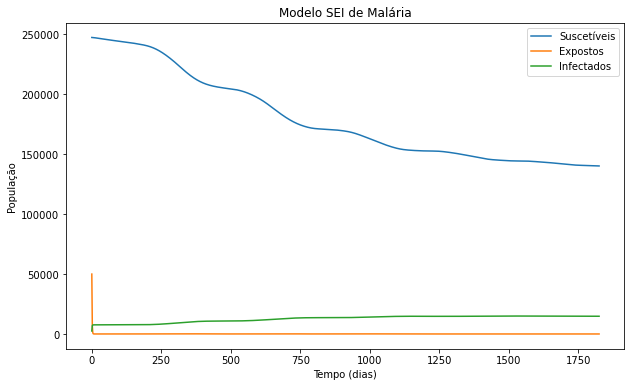

In [14]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model_plot_rates, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0, 0, 0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M, a_values, b3_values, tau_M_values = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [15]:
# Executa o novo modelo com resultados das taxas
sol = solve_ivp(model_plot_rates, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0, 0.0241, 0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

a_values = sol.y[6]
print(a_values)
b3_values = sol.y[7]
tau_M_values = sol.y[8]

26.479531827782463
0.02409676240499894
 
26.479531806034103
0.02409676180915347
 
26.47953171338579
0.024096759270843503
 
26.479531656187447
0.02409675770376564
 
26.479531570389945
0.024096755353149132
 
26.479531215240787
0.024096745623035213
 
26.47953110283729
0.024096742543487322
 
26.47953128407359
0.02409674750886547
 
26.479531158602306
0.024096744071296018
 
26.479530411351035
0.024096723598658467
 
26.479530522881078
0.02409672665427606
 
26.479529963637532
0.02409671133253508
 
26.47952965294665
0.0240967028204561
 
26.47952965294665
0.0240967028204561
 
26.47953161029892
0.024096756446545728
 
26.479531392815367
0.02409675048809222
 
26.479530136243575
0.024096716061467773
 
26.479528508979357
0.024096671478886444
 
26.479527936995616
0.024096655808099037
 
26.4795270790199
0.024096632301915007
 
26.479523527524314
0.02409653500066611
 
26.479522403487618
0.024096504205140173
 
26.47952421585329
0.02409655385899417
 
26.47952296113866
0.02409651948325091
 
26.4795154886099

25.87488442344606
0.007531080094412521
 
25.87488442344606
0.007531080094412521
 
25.916822474443073
0.008680067792960867
 
25.91192272813462
0.008545828168071737
 
25.88477955907264
0.007802179700620252
 
25.872587636127186
0.007468154414443408
 
25.871445814290635
0.007436871624400906
 
25.869741323023437
0.007390173233518776
 
25.862791623088828
0.007199770495584294
 
25.860627830350868
0.00714048850276347
 
25.864125188789032
0.007236306542165221
 
25.86169915949826
0.0071698399862537
 
25.84770006253568
0.00678630308316926
 
25.849740206191427
0.006842197429902076
 
25.839686672716283
0.006566758156610456
 
25.834293267987448
0.006418993643491686
 
25.834293267987448
0.006418993643491686
 
25.87053294057192
0.00741186138553201
 
25.86624509033195
0.007294386036491768
 
25.84274247667199
0.006650478812931199
 
25.83237900581204
0.006366548104439418
 
25.831428683737617
0.006340511883222333
 
25.83001173329192
0.006301691323066223
 
25.82425586185555
0.006143996215220545
 
25.822471

25.79922453381222
0.005458206405814254
 
25.77225749650279
0.004719383465829793
 
25.772795601679064
0.004734126073398981
 
25.773610889862923
0.004756462735970443
 
25.777089199437036
0.004851758888685877
 
25.77822471130008
0.0048828688027418785
 
25.776402053074403
0.004832932960942501
 
25.77765929012175
0.0048673778115547696
 
25.78557423968722
0.005084225744855348
 
25.784346635740235
0.005050592760006396
 
25.79066442895746
0.005223682985135834
 
25.794348619032895
0.005324619699531343
 
25.794348619032895
0.005324619699531343
 
25.77323044304599
0.004746039535506511
 
25.775329229531422
0.004803540535107426
 
25.788671323611187
0.005169077359210554
 
25.79573630498098
0.005362638492629569
 
25.79643641769576
0.005381819662897462
 
25.797494410338757
0.005410805762705636
 
25.801973373411485
0.005533517079766677
 
25.803424219348344
0.005573266283516225
 
25.801092796572668
0.005509391686922371
 
25.80270243991622
0.005553491504553956
 
25.812698507156572
0.005827356360453988
 


26.344586150875536
0.020399620571932446
 
26.348332733486384
0.02050226667085979
 
26.363857764954258
0.020927609998746745
 
26.36877597906536
0.021062355590831784
 
26.36084696214094
0.02084512225043667
 
26.3663357469034
0.020995499915161576
 
26.399059843009976
0.021892050493423958
 
26.394173543739686
0.021758179280539316
 
26.41867265465083
0.022429387798652847
 
26.432274313647508
0.022802035990342633
 
26.432274313647508
0.022802035990342633
 
26.34073220260565
0.020294032948099974
 
26.342549740555487
0.020343828508369473
 
26.345276866481935
0.02041854428717627
 
26.356574986214827
0.020728081814104817
 
26.36015362643727
0.020826126751706
 
26.35438415165525
0.02066805894945886
 
26.358378057193196
0.020777481018991635
 
26.38219066121389
0.021429881129147642
 
26.37863431036717
0.021332446859374434
 
26.39647103311738
0.021821124194996648
 
26.406382272072147
0.022092664988277957
 
26.406382272072147
0.022092664988277957
 
26.344008215548225
0.020383786727348596
 
26.3509241

26.96214516213743
0.0373190455380117
 
26.963058154930916
0.03734405903920315
 
26.96442025195686
0.03738137676594132
 
26.96996370430697
0.03753325217279366
 
26.971686213550868
0.03758044420687305
 
26.968901277540787
0.03750414459015852
 
26.970833580354668
0.03755708439327854
 
26.981941085489552
0.037861399602453445
 
26.980327071945343
0.037817180053297025
 
26.9882638916848
0.0380346271694465
 
26.992503480087546
0.03815078027637108
 
26.992503480087546
0.03815078027637108
 
26.963787772843435
0.03736404857105299
 
26.96721111220631
0.03745783869058382
 
26.98585601027942
0.03796865781587448
 
26.99397209846793
0.03819101639638156
 
26.99470066801389
0.038210977205859996
 
26.995786334562922
0.038240721494874536
 
27.000188260248702
0.03836132219859454
 
27.001550438637516
0.03839864215445244
 
26.999346723000915
0.03833826638358668
 
27.00087651129868
0.03838017839174466
 
27.009599711941142
0.03861917019016824
 
27.008340083597385
0.038584659824585865
 
27.01450558042071
0.038

26.685301748868525
0.0297342944895486
 
26.68199000069174
0.02964356166278738
 
26.662089846404225
0.029098351956280095
 
26.665078777176618
0.029180240470592225
 
26.650027800274994
0.028767884939040905
 
26.641599272896748
0.028536966380732786
 
26.641599272896748
0.028536966380732786
 
26.693870805209404
0.029969063156421977
 
26.6881648073541
0.02981273444805746
 
26.65468996022188
0.02889561534854462
 
26.638437458140185
0.02845034131890914
 
26.63685418071286
0.028406963855146794
 
26.634476331449882
0.028341817299996727
 
26.624596781247224
0.02807114469170472
 
26.621457890194076
0.02798514767654999
 
26.626516125458593
0.028123729464618958
 
26.623015851663617
0.028027831552427815
 
26.602026637295307
0.02745278458343302
 
26.60517440802582
0.027539024877419715
 
26.5893402738182
0.027105212981320462
 
26.580491179239903
0.026862772033969914
 
26.580491179239903
0.026862772033969914
 
26.635582831421203
0.02837213236770416
 
26.62954387044545
0.028206681382067056
 
26.59424058

25.840399628409
0.00658629118928761
 
25.838724026031528
0.006540384274836346
 
25.841432107246096
0.0066145782807149126
 
25.83955369817038
0.0065631150183665535
 
25.828702762830787
0.006265829118651654
 
25.83028553135267
0.006309192639799097
 
25.822480239039532
0.006095349014781655
 
25.818286416358
0.005980449763232818
 
25.818286416358
0.005980449763232818
 
25.84639109906865
0.0067504410703739534
 
25.843073072421387
0.006659536230722882
 
25.824854242244324
0.006160390198474601
 
25.816613186323583
0.005934607844481676
 
25.815782932955774
0.005911861176870469
 
25.814545521960355
0.005877959505763106
 
25.809525532014817
0.005740425534652479
 
25.807971150039524
0.005697839727110211
 
25.81048558340683
0.00576672831251586
 
25.808740225846467
0.005718910297163443
 
25.79877629253136
0.005445925822776977
 
25.80021635861963
0.005485379688208973
 
25.7931631794515
0.0052921419027808
 
25.78942674769121
0.005189773909348157
 
25.78942674769121
0.005189773909348157
 
25.816806482

25.76464735415307
0.004510886415152553
 
25.775987794768827
0.0048215834183239995
 
25.78211091889278
0.004989340243637768
 
25.782721284656688
0.005006062593333879
 
25.78364478895796
0.005031364081039987
 
25.78756878335952
0.005138870776973154
 
25.788844581081875
0.0051738241392294175
 
25.786795545089603
0.005117686166838409
 
25.788209608972714
0.005156427643088021
 
25.797048691074863
0.005398594276023613
 
25.795684250982106
0.005361212355674093
 
25.80268419403134
0.005552991617296937
 
25.80674297117505
0.005664190991097258
 
25.80674297117505
0.005664190991097258
 
25.783214031248114
0.005019562499948301
 
25.785586430329868
0.00508455973506484
 
25.800481618380644
0.005492647078921715
 
25.808723607852276
0.00571845500965135
 
25.809724187380095
0.005745868147399815
 
25.81123785064622
0.005787338373868963
 
25.81766597869964
0.005963451471222983
 
25.819754679191185
0.0060206761422242
 
25.816399747896313
0.005928760216337291
 
25.818715199932836
0.005992197258433816
 
25.

27.00468046693954
0.038484396354507906
 
27.005698562491588
0.03851228938333114
 
27.00981638446788
0.03862510642377746
 
27.01108717223792
0.03865992252706631
 
27.009030463252035
0.03860357433567215
 
27.010458673435554
0.03864270338179597
 
27.018558749093398
0.03886462326283277
 
27.017394091285823
0.03883271482974853
 
27.023076484802615
0.03898839684390724
 
27.026062620498866
0.039070208780790816
 
27.026062620498866
0.039070208780790816
 
27.005226117498722
0.03849934568489646
 
27.007776931160635
0.03856923099070228
 
27.02136471152539
0.03894149894590106
 
27.027116002704584
0.03909906856724885
 
27.027636624614946
0.03911333218123135
 
27.02840996153078
0.03913451949399394
 
27.031513916668096
0.03921955936076973
 
27.032463609329557
0.03924557833779605
 
27.03092457921311
0.039203413129126265
 
27.031994421736265
0.03923272388318529
 
27.037958323188537
0.03939611844352152
 
27.03711264704702
0.039372949234164914
 
27.04119535837388
0.039484804339010374
 
27.04329276014612


25.837399625204867
0.006504099320681248
 
25.836477151974485
0.006478826081492698
 
25.835101027840317
0.006441124050419593
 
25.829501998075266
0.006287725974664772
 
25.82776273889049
0.006240075038095529
 
25.83057488216507
0.006317120059316954
 
25.828623631232933
0.006263661129669356
 
25.817413833474745
0.005956543382869698
 
25.819041957110155
0.006001149509867222
 
25.811038526050293
0.005781877426035386
 
25.80676643586342
0.005664833859271733
 
25.80676643586342
0.005664833859271733
 
25.83759262629933
0.006509387021899403
 
25.836765454912296
0.006486724792117661
 
25.835530779933354
0.0064528980803658185
 
25.830497943190316
0.006315012142200409
 
25.828931351816745
0.006272091830595725
 
25.831463534463808
0.006341466697638529
 
25.829706975664482
0.006293341799026875
 
25.819574592989063
0.006015742273672932
 
25.82105091469011
0.006056189443564665
 
25.81377641979129
0.005856888213459924
 
25.809874202626872
0.005749978154160848
 
25.809874202626872
0.005749978154160848


25.7865471131265
0.005110879811684864
 
25.78779269691516
0.005145005394935896
 
25.78579217627907
0.005090196610385448
 
25.78717276512971
0.005128020962457788
 
25.795802088121278
0.0053644407704459204
 
25.79447007465358
0.005327947250783017
 
25.801303532194495
0.005515165265602576
 
25.805265664371127
0.005623716832085642
 
25.805265664371127
0.005623716832085642
 
25.78229531326371
0.004994392144211183
 
25.78461166218857
0.005057853758590936
 
25.799153373562582
0.00545625680993372
 
25.806754144388783
0.005664497106541971
 
25.807504341622014
0.0056850504553976056
 
25.808637069892708
0.005716084106649487
 
25.813420387895313
0.005847133914940044
 
25.81496587722168
0.005889476088265194
 
25.812481453821746
0.005821409693746438
 
25.814197245210238
0.005868417676992782
 
25.82480449471601
0.006159027252493356
 
25.823179316576326
0.006114501824008884
 
25.8314752840898
0.0063417886052000065
 
25.836241641858468
0.006472373749547028
 
25.836241641858468
0.006472373749547028
 
25

26.466371362575643
0.023736201714401137
 
26.47002846228486
0.023836396226982387
 
26.491759630536617
0.024431770699633298
 
26.48852200408205
0.024343068604987632
 
26.504732940673158
0.024787203854059078
 
26.513711754646334
0.02503319875743376
 
26.513711754646334
0.02503319875743376
 
26.456853546857264
0.023475439639925006
 
26.46320020591562
0.02364932071001693
 
26.49973598969928
0.024650301087651424
 
26.516977864188316
0.025122681210638764
 
26.518609816010244
0.025167392219458698
 
26.521056336069368
0.025234420166284004
 
26.53116474784782
0.025511362954734794
 
26.53435748936893
0.02559883532517611
 
26.529208016743613
0.025457753883386627
 
26.53277392841418
0.02555545009353914
 
26.55392364587749
0.026134894407602412
 
26.5507769512172
0.026048683594991694
 
26.5665174187783
0.026479929281597227
 
26.57521929364233
0.026718336812118607
 
26.57521929364233
0.026718336812118607
 
26.519918541593203
0.02520324771488223
 
26.52611438003059
0.025372996713166854
 
26.5616695334

27.052884680737918
0.03980505974624429
 
27.051468755135232
0.03976626726397893
 
27.051468755135232
0.03976626726397893
 
27.058250485818135
0.03995206810460641
 
27.057748660360037
0.03993831946191878
 
27.053616115001237
0.03982509904112974
 
27.050925313037954
0.03975137843939596
 
27.050647344066043
0.03974376285112442
 
27.050222585696698
0.03973212563552594
 
27.048364849788847
0.03968122876133823
 
27.047743542065948
0.03966420663194375
 
27.048737413595813
0.03969143598892634
 
27.048053783328715
0.0396727063925675
 
27.043569901330084
0.03954986031041322
 
27.044283879113493
0.03956942134557512
 
27.040546409896933
0.039467024928683064
 
27.03830060454948
0.03940549601505421
 
27.03830060454948
0.03940549601505421
 
27.0504213281067
0.039737570633060264
 
27.04931373800256
0.039707225698700235
 
27.041741857782757
0.039499776925554946
 
27.037428645100146
0.03938160671507245
 
27.036986337177765
0.03936948868980175
 
27.03631497326865
0.039351095158045135
 
27.033435281826666

26.364536843970473
0.0209462149033006
 
26.35816183130828
0.020771557022144616
 
26.321423704276558
0.019765032993878266
 
26.304008061451352
0.01928789209455755
 
26.30233664069939
0.01924209974518875
 
26.299830713228584
0.019173444198043354
 
26.289473832193476
0.018889694032697933
 
26.286201609118113
0.0188000440854277
 
26.291479037846678
0.01894463117388154
 
26.287824651871627
0.018844511010181534
 
26.266137967081296
0.018250355262501208
 
26.269365867627567
0.0183387908939059
 
26.253214637495095
0.017896291438221735
 
26.24428082486973
0.017651529448485706
 
26.24428082486973
0.017651529448485706
 
26.300996171589734
0.019205374564102262
 
26.294648945082344
0.019031477947461427
 
26.25819024296801
0.018032609396383775
 
26.24103143972773
0.017562505198019992
 
26.239408273978597
0.01751803490352317
 
26.236975463215238
0.017451382553842095
 
26.22693057519781
0.01717618014240568
 
26.223760215519583
0.017089320973139224
 
26.228874141074133
0.01722942852257895
 
26.22533253

 
25.742152807398693
0.0038945974629778436
 
25.74182631908123
0.003885652577567918
 
25.74236596481355
0.003900437392152049
 
25.741984945744786
0.003889998513555742
 
25.740407788859418
0.003846788735874428
 
25.74056788271299
0.003851174868849033
 
25.740031294355266
0.003836473817952443
 
25.74002059311872
0.0038361806333895936
 
25.74002059311872
0.0038361806333895936
 
25.744040215247427
0.003946307267052756
 
25.743864969273996
0.003941506007506714
 
25.743609364869393
0.00393450314710661
 
25.742644114315738
0.003908057926458526
 
25.742369780974176
0.003900541944497935
 
25.742819509034955
0.003912863261231616
 
25.742504007769636
0.003904219390948889
 
25.74101222428044
0.0038633486104229504
 
25.7411927477906
0.003868294460016374
 
25.740436481020247
0.003847574822472471
 
25.74017717478108
0.0038404705419473927
 
25.74017717478108
0.0038404705419473927
 
25.743727175483432
0.003937730835162483
 
25.74310804773651
0.003920768431137202
 
25.74063019373149
0.003852882020040803

25.999634301349086
0.010948884968468084
 
25.997204753450408
0.010882322012339901
 
26.009473369168223
0.011218448470362234
 
26.016380982980312
0.011407698163844128
 
26.016380982980312
0.011407698163844128
 
25.973978761435305
0.010245993463980915
 
25.97855575499443
0.010371390547792604
 
26.00566390830788
0.011114079679667925
 
26.01894056943964
0.011477823820264048
 
26.02022360105196
0.011512975371286533
 
26.02215217603155
0.011565813041960245
 
26.03018619813618
0.01178592323660768
 
26.032745831538872
0.011856050179147133
 
26.028622735737354
0.01174308865033843
 
26.031474953327137
0.011821231598003726
 
26.04866667732258
0.012292237734865145
 
26.046078797875843
0.012221336928105255
 
26.059130681068634
0.012578922769003634
 
26.066461862485497
0.01277977705439713
 
26.066461862485497
0.01277977705439713
 
26.021254493468067
0.011541218999125089
 
26.02615899160174
0.011675588811006535
 
26.05508231760699
0.012468008701561286
 
26.071258477991336
0.012911191177844774
 
26.07

26.76915333421996
0.03203159819780712
 
26.771268227431328
0.032089540477570594
 
26.77996307276699
0.03232775541827364
 
26.78269474641581
0.03240259579221394
 
26.77828544302665
0.032281792959634216
 
26.781340748904864
0.03236549996999622
 
26.799280397566363
0.032856997193598955
 
26.79663115413537
0.03278441518179089
 
26.809812808730218
0.033145556403567575
 
26.81702376915151
0.033343116963055065
 
26.81702376915151
0.033343116963055065
 
26.770285168337814
0.0320626073517209
 
26.77562770343822
0.03220897817638959
 
26.80577183953061
0.03303484491864682
 
26.8196255811279
0.03341439948295617
 
26.82092240376025
0.03344992887014379
 
26.82286250982209
0.033503082460879165
 
26.83082732486951
0.03372129657176736
 
26.833325784609926
0.03378974752355957
 
26.82929199891212
0.033679232846907325
 
26.8320876166896
0.033755825114783485
 
26.848454454267813
0.03420423162377566
 
26.846042761506244
0.03413815784948609
 
26.858023641812203
0.03446640114553976
 
26.864557299409885
0.0346

26.960492776866182
0.03727377470866249
 
26.955651774489482
0.037141144506561106
 
26.955651774489482
0.037141144506561106
 
26.98436260010818
0.037927742468717246
 
26.981384941823645
0.037846162789688866
 
26.96313655995492
0.03734620712205252
 
26.953815260233522
0.03709082904749372
 
26.952891522081387
0.03706552115291468
 
26.951499080696472
0.0370273720738759
 
26.94564841986624
0.036867079996335345
 
26.94376773516535
0.0368155543880917
 
26.946793242425382
0.036898444997955644
 
26.944702504118823
0.03684116449640606
 
26.931895314114893
0.036490282578490185
 
26.93384519572951
0.03654370399258929
 
26.92393421859326
0.03627217037241804
 
26.918285007344934
0.03611739746150502
 
26.918285007344934
0.03611739746150502
 
26.95214779820813
0.037045145156387106
 
26.948591183460746
0.03694770365645875
 
26.927028692681944
0.036356950484436774
 
26.91620966382612
0.03606053873496214
 
26.915167027493254
0.036031973355979525
 
26.913596886058457
0.035988955782423435
 
26.907018957604

26.12379612545146
0.014350578779492001
 
26.10800757533144
0.013918015762505119
 
26.10648071793015
0.013876184052880793
 
26.10419410189931
0.013813537038337221
 
26.09477646221906
0.013555519512850892
 
26.091812030829164
0.013474302214497608
 
26.096595680395314
0.013605361106720894
 
26.093281742080073
0.013514568276166348
 
26.07375269037339
0.012979525763654465
 
26.076644457636863
0.013058752264023617
 
26.062228226434197
0.012663787025594397
 
26.05431158323176
0.012446892691281106
 
26.05431158323176
0.012446892691281106
 
26.1052571788369
0.013842662433887654
 
26.099475632599987
0.013684263906848909
 
26.066655152996226
0.012785072684828078
 
26.051495355437396
0.012369735765408072
 
26.050090526354296
0.012331247297377937
 
26.047987413612702
0.012273627770210984
 
26.03933515433362
0.012036579570784096
 
26.036614871366552
0.011962051270316465
 
26.04100531142552
0.012082337299329234
 
26.037963343896887
0.011998995723202356
 
26.020076900997704
0.01150895619171789
 
26.02

 
25.74367450024541
0.003936287677956446
 
25.740132643488153
0.0038392505065246887
 
25.740288164065042
0.0038435113442476885
 
25.74235233708904
0.003900064029836714
 
25.744030315065398
0.0039460360291889525
 
25.744214368538927
0.003951078590107546
 
25.74449812810453
0.003958852824781647
 
25.745770656539946
0.003993716617532735
 
25.74620624141988
0.004005650449859699
 
25.745511706034506
0.003986622083137112
 
25.745988169683404
0.0039996758817370534
 
25.749232356444264
0.004088557710801703
 
25.74870401862325
0.004074082702006825
 
25.75150865209749
0.004150921975273613
 
25.753234193498216
0.004198197082142855
 
25.753234193498216
0.004198197082142855
 
25.74436499035802
0.003955205215288146
 
25.745114681245653
0.003975744691661683
 
25.75060163457786
0.004126072180215258
 
25.754051037466343
0.0042205763689408754
 
25.754468532150966
0.004232014579478484
 
25.755106104080966
0.0042494823035880615
 
25.757889598759522
0.004325742431767699
 
25.758818895085295
0.0043512026050

26.114612880338814
0.014098983022981178
 
26.13733170760352
0.014721416646671702
 
26.133916162785308
0.01462784007630977
 
26.151125904984895
0.01509933986259981
 
26.160774009786945
0.01536367150101214
 
26.160774009786945
0.01536367150101214
 
26.101075957677136
0.013728108429510525
 
26.107574646548574
0.0139061546999609
 
26.14579231506526
0.014953214111376978
 
26.164601799348546
0.015468542447905326
 
26.16651911349038
0.015521071602476146
 
26.169399306833466
0.015599981009136005
 
26.181374146108574
0.01592805879749514
 
26.185181312334546
0.016032364721494368
 
26.179046758898572
0.0158642947643444
 
26.183291511310465
0.0159805893509716
 
26.208773180428523
0.016678717272014282
 
26.20494890963306
0.016573942729672848
 
26.224194140744018
0.01710120933545251
 
26.234957207635077
0.017396087880413025
 
26.234957207635077
0.017396087880413025
 
26.16390941372665
0.015449572978812281
 
26.165479416522228
0.015492586754033599
 
26.167837268126224
0.015557185428115685
 
26.177632

 
26.88457493734708
0.03519383389991993
 
26.888884082570403
0.035311892673161684
 
26.912874460514463
0.035969163301766055
 
26.923758865194046
0.03626736616969984
 
26.924793317481097
0.03629570732824919
 
26.92633844284411
0.03633803952997556
 
26.932650195742127
0.03651096426690755
 
26.93461943861464
0.03656491612642844
 
26.931437521644586
0.036477740319029714
 
26.933644183376355
0.036538196804831606
 
26.946429611983127
0.03688848252008565
 
26.94456040918713
0.036837271484578854
 
26.95379344932594
0.03709023148838186
 
26.958770998539574
0.03722660269971432
 
26.958770998539574
0.03722660269971432
 
26.925620702367315
0.036318375407323654
 
26.92951130762517
0.036424967332196384
 
26.950981077618472
0.037013180208725224
 
26.960547026579086
0.03727526100216669
 
26.961429625516203
0.03729944179496443
 
26.96274673906531
0.03733552709767967
 
26.96811178739512
0.03748251472315394
 
26.969780467664144
0.037528231990798425
 
26.967082951699304
0.03745432744381651
 
26.9689543806

 
26.76148456320145
0.031821494882231446
 
26.80846766711987
0.033108703208763544
 
26.803395999528718
0.03296975341174565
 
26.773358069403418
0.03214679642201142
 
26.759510197032228
0.031767402658417154
 
26.75852129293577
0.03174030939550056
 
26.757035794393108
0.03169961080529059
 
26.750859613407773
0.0315304003673362
 
26.748895851889177
0.03147659868189522
 
26.75206003552062
0.03156328864440054
 
26.749870641126563
0.031503305236344155
 
26.736721553436265
0.03114305625852777
 
26.738695912141296
0.03119714827784368
 
26.728755073617194
0.030924796537457323
 
26.72318889277906
0.030772298432302975
 
26.72318889277906
0.030772298432302975
 
26.75772709787946
0.031718550626834485
 
26.753953142578357
0.03161515459118783
 
26.731834066030817
0.031009152493994958
 
[2.41000000e-02 6.76108130e-02 1.10099961e-01 1.51565081e-01
 1.92004799e-01 2.31418730e-01 2.69807477e-01 3.07172634e-01
 3.43516779e-01 3.78843478e-01 4.13157275e-01 4.46463693e-01
 4.78769226e-01 5.10081333e-01 5.40

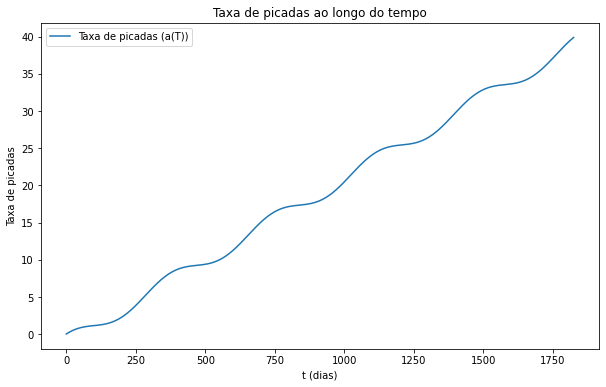

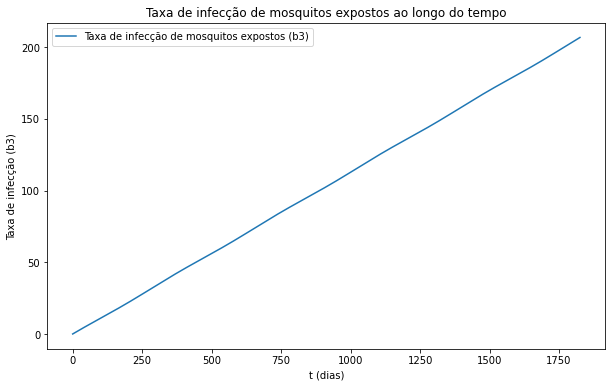

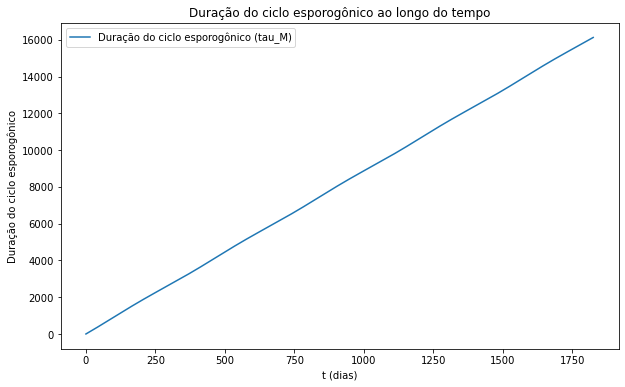

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(sol.t, a_values, label='Taxa de picadas (a(T))')
plt.xlabel('t (dias)')
plt.ylabel('Taxa de picadas')
plt.title('Taxa de picadas ao longo do tempo')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sol.t, b3_values, label='Taxa de infecção de mosquitos expostos (b3)')
plt.xlabel('t (dias)')
plt.ylabel('Taxa de infecção (b3)')
plt.title('Taxa de infecção de mosquitos expostos ao longo do tempo')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sol.t, tau_M_values, label='Duração do ciclo esporogônico (tau_M)')
plt.xlabel('t (dias)')
plt.ylabel('Duração do ciclo esporogônico')
plt.title('Duração do ciclo esporogônico ao longo do tempo')
plt.legend()
plt.show()

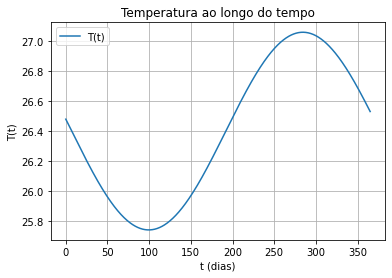

In [17]:
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))
        
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao longo do tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

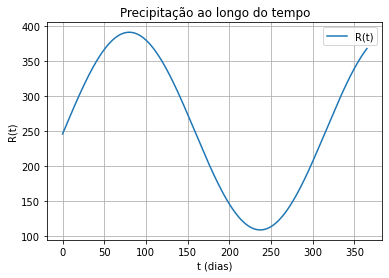

In [18]:
def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))
        
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao longo do tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

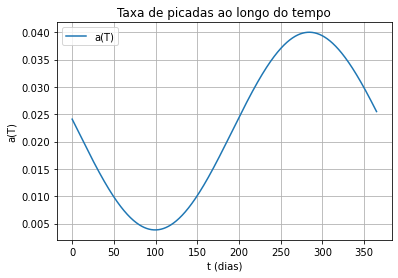

In [19]:
def biting_rate(t):
        return (max(1e-5, T(t)-T_linha))/D1
        
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
biting_values = [biting_rate(t) for t in t_values]

# Plotando
plt.plot(t_values, biting_values, label='a(T)')
plt.title('Taxa de picadas ao longo do tempo')
plt.xlabel('t (dias)')
plt.ylabel('a(T)')
plt.legend()
plt.grid(True)
plt.show()

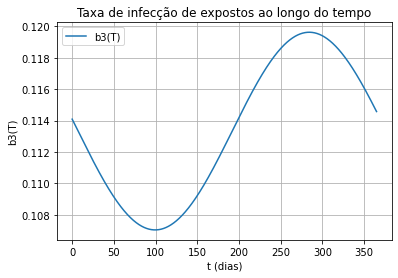

In [20]:
def exposed_to_infected_rate(t):
        return  (max(1e-5, T(t)-Tmin))/DD
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
infection_values = [exposed_to_infected_rate(t) for t in t_values]

# Plotando
plt.plot(t_values, infection_values, label='b3(T)')
plt.title('Taxa de infecção de expostos ao longo do tempo')
plt.xlabel('t (dias)')
plt.ylabel('b3(T)')
plt.legend()
plt.grid(True)
plt.show()

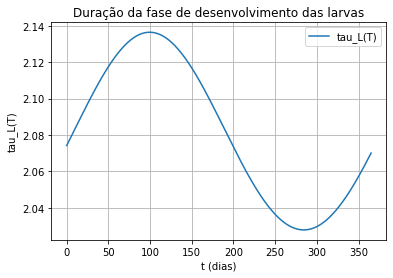

In [21]:
def larvae_development_rate(t):
        return 1 / (c1 * T(t) + c2)

# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
larvae_dev = [larvae_development_rate(t) for t in t_values]

# Plotando
plt.plot(t_values, larvae_dev, label='tau_L(T)')
plt.title('Duração da fase de desenvolvimento das larvas')
plt.xlabel('t (dias)')
plt.ylabel('tau_L(T)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# O gráfico não indica bem a evolução da taxa de picadas por ser diariamente extremamente próxima de 1, acima de 0.9999 

# def daily_survival_rate(t):
#         return np.exp(-1 / (A*T(t)**2 + B*T(t) + C))

# print(np.exp(-1 / (A*T(0)**2 + B*T(0) + C)))    
# # Pontos no tempo
# t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
# daily_survival = [daily_survival_rate(t) for t in t_values]

# # Plotando
# plt.plot(t_values, daily_survival, label='p(T)')
# plt.title('Taxa diária de sobrevivência dos mosquitos')
# plt.xlabel('t (dias)')
# plt.ylabel('p(T)')
# plt.legend()
# plt.grid(True)
# plt.show()

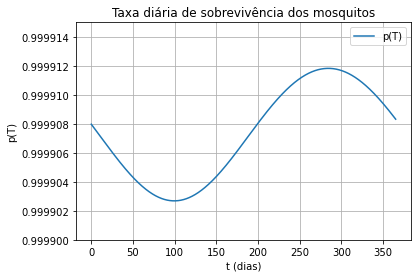

In [23]:
def daily_survival_rate(t):
    return np.exp(-1 / (A * T(t)**2 + B * T(t) + C))

# Set up the time points
t_values = np.linspace(0, 365, 1000)

# Calculate daily survival rates
daily_survival = [daily_survival_rate(t) for t in t_values]

# Plotando
plt.plot(t_values, daily_survival, label='p(T)')
plt.title('Taxa diária de sobrevivência dos mosquitos')
plt.xlabel('t (dias)')
plt.ylabel('p(T)')
plt.legend()
plt.grid(True)

# Set y-axis limits
plt.ylim(0.9999, 0.999915)

plt.ticklabel_format(useOffset=False, style='plain')

plt.show()

In [24]:
def model_plot_rates(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M, a_curr, b3_curr, tau_M_curr = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    p_curr = p(T_curr)
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    print(p_curr)
    print(' ')
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt, a_curr, b3_curr, tau_M_curr]

0.9999079731770024
 
0.999907973176868
 
0.9999079731762955
 
0.999907973175942
 
0.9999079731754119
 
0.9999079731732172
 
0.9999079731725227
 
0.9999079731736427
 
0.9999079731728673
 
0.9999079731682498
 
0.9999079731689389
 
0.9999079731654831
 
0.9999079731635632
 
0.9999079731635632
 
0.9999079731756585
 
0.9999079731743146
 
0.9999079731665497
 
0.9999079731564942
 
0.9999079731529597
 
0.9999079731476579
 
0.9999079731257117
 
0.9999079731187658
 
0.9999079731299652
 
0.9999079731222118
 
0.999907973076036
 
0.9999079730829279
 
0.9999079730483698
 
0.9999079730291708
 
0.9999079730291708
 
0.999907973150124
 
0.9999079731366848
 
0.9999079730590359
 
0.9999079729584799
 
0.9999079729231343
 
0.9999079728701159
 
0.9999079726506508
 
0.9999079725811904
 
0.9999079726931863
 
0.9999079726156508
 
0.9999079721538779
 
0.9999079722227998
 
0.9999079718772036
 
0.9999079716852035
 
0.9999079716852035
 
0.9999079728947776
 
0.9999079727603836
 
0.9999079719838697
 
0.999907970978243

0.9999027484283044
 
0.9999027484283044
 
0.9999028281424995
 
0.9999028177091657
 
0.9999027651301715
 
0.9999027447629142
 
0.9999027429716294
 
0.9999027403365001
 
0.9999027300906803
 
0.9999027270703745
 
0.999902731993074
 
0.99990272855541
 
0.9999027108489991
 
0.9999027131904729
 
0.9999027025158409
 
0.9999026977377417
 
0.9999026977377417
 
0.9999027415545045
 
0.9999027350802052
 
0.9999027055261759
 
0.9999026953559387
 
0.9999026942679899
 
0.9999026927648109
 
0.9999026881869918
 
0.9999026872903091
 
0.9999026888672019
 
0.9999026877019697
 
0.9999026876180951
 
0.9999026868851838
 
0.9999026931911339
 
0.9999026995320448
 
0.9999026995320448
 
0.9999026963014115
 
0.9999026956189673
 
0.9999026946399637
 
0.9999026911578354
 
0.9999026902472445
 
0.9999026917609206
 
0.9999026906874902
 
0.9999026866723484
 
0.9999026870130173
 
0.9999026862183464
 
0.9999026867630498
 
0.9999026867630498
 
0.9999026950886827
 
0.9999026927840308
 
0.9999026862201137
 
0.99990268714103

0.9999087630554322
 
0.9999087772299945
 
0.9999087984578814
 
0.9999088858848495
 
0.999908913402629
 
0.9999088689970509
 
0.9999088997599913
 
0.9999090809918453
 
0.9999090541642033
 
0.9999091878649982
 
0.999909261232287
 
0.999909261232287
 
0.999908757523431
 
0.9999087689414837
 
0.9999087860466651
 
0.9999088565668794
 
0.9999088787887715
 
0.9999088429354192
 
0.999908867770114
 
0.9999090144196319
 
0.9999089926716391
 
0.9999091012083665
 
0.9999091609385449
 
0.9999091609385449
 
0.9999087780934187
 
0.9999088213646691
 
0.9999090678475462
 
0.9999091828259961
 
0.9999091937481747
 
0.9999092101043091
 
0.9999092774574366
 
0.999909298654771
 
0.9999092644481368
 
0.999909288145739
 
0.9999094277509547
 
0.9999094070837099
 
0.9999095100989478
 
0.9999095666521399
 
0.9999095666521399
 
0.999909202500265
 
0.9999092438521215
 
0.9999094784694759
 
0.9999095897502086
 
0.9999096012675065
 
0.9999096185035256
 
0.9999096893341345
 
0.9999097115762935
 
0.9999096756717081
 


0.9999068502971037
 
0.9999068872480337
 
0.9999068616650582
 
0.9999067094809735
 
0.9999067321720709
 
0.9999066184941686
 
0.9999065554638316
 
0.9999065554638316
 
0.9999069537915243
 
0.9999069094251241
 
0.9999066535515494
 
0.9999065323002012
 
0.9999065207238823
 
0.9999065033664934
 
0.9999064316134436
 
0.9999064089380572
 
0.9999064455075937
 
0.999906420185501
 
0.9999062698497861
 
0.9999062922329434
 
0.9999061802124902
 
0.9999061182253717
 
0.9999061182253717
 
0.9999065114392649
 
0.999906467470079
 
0.999906214728095
 
0.9999060953356838
 
0.9999060839008933
 
0.9999060667614978
 
0.9999059959836675
 
0.9999059736414201
 
0.9999060096796286
 
0.9999059847221158
 
0.9999058368622264
 
0.9999058588426938
 
0.999905748958811
 
0.9999056882855187
 
0.9999056882855187
 
0.9999060747320179
 
0.9999060313380124
 
0.9999057827836836
 
0.9999056662466546
 
0.9999056552414878
 
0.999905638751784
 
0.999905570730154
 
0.9999055492825948
 
0.9999055838835301
 
0.9999055599180825


0.9999050809725682
 
0.9999042501959461
 
0.9999042586357986
 
0.9999042713282265
 
0.9999043242799899
 
0.9999043411761565
 
0.9999043139656122
 
0.9999043327855461
 
0.9999044465363065
 
0.9999044293800022
 
0.9999045160220023
 
0.9999045648102062
 
0.9999045648102062
 
0.9999042654194402
 
0.9999042977213837
 
0.999904489117561
 
0.9999045828892245
 
0.9999045919517286
 
0.999904605574064
 
0.999904662322901
 
0.9999046804032382
 
0.9999046512791846
 
0.9999046714262043
 
0.9999047928604027
 
0.9999047745813874
 
0.999904866767222
 
0.9999049185422627
 
0.9999049185422627
 
0.9999045992333366
 
0.9999046338762869
 
0.9999048381746239
 
0.9999049501166264
 
0.9999049659566142
 
0.9999049897818356
 
0.9999050892173664
 
0.9999051209543205
 
0.9999050698447824
 
0.9999051051934909
 
0.9999053188483962
 
0.9999052866322841
 
0.9999054492543096
 
0.9999055407155774
 
0.9999055407155774
 
0.9999049417901432
 
0.999904953442842
 
0.9999049709575316
 
0.9999050439049627
 
0.999905067139859


0.9999114307566129
 
0.9999115737796099
 
0.9999115594222914
 
0.9999114689417623
 
0.9999114216062841
 
0.9999114169934529
 
0.9999114100271892
 
0.9999113805926523
 
0.999911371076511
 
0.9999113863726287
 
0.9999113758096113
 
0.9999113104316643
 
0.9999113204568002
 
0.9999112692512543
 
0.999911239797626
 
0.999911239797626
 
0.9999114132745824
 
0.9999113954302473
 
0.9999112853046455
 
0.9999112285897179
 
0.9999112229483822
 
0.9999112144397366
 
0.999911178625927
 
0.9999111670926993
 
0.9999111856415912
 
0.9999111728263819
 
0.9999110940633577
 
0.9999111060829022
 
0.9999110448905
 
0.999911009904626
 
0.999911009904626
 
0.9999112184045165
 
0.9999111966520535
 
0.9999110640224973
 
0.9999109970556244
 
0.9999109905967414
 
0.9999109808655349
 
0.9999109400393236
 
0.9999109269359763
 
0.9999109480203637
 
0.9999109334476349
 
0.9999108444219059
 
0.9999108579508134
 
0.99991078927002
 
0.9999107502109018
 
0.9999107502109018
 
0.9999109853984308
 
0.9999109605619078
 
0.9

0.9999027797727789
 
0.9999028152910696
 
0.9999028096332689
 
0.9999028392558106
 
0.9999028570603127
 
0.9999028570603127
 
0.9999027610378992
 
0.9999027698001971
 
0.9999028297795709
 
0.9999028638572452
 
0.9999028673042943
 
0.9999028725355156
 
0.9999028949616361
 
0.9999029023177421
 
0.9999028905181786
 
0.9999028986527819
 
0.9999029502852178
 
0.9999029422340361
 
0.9999029838136008
 
0.9999030082114828
 
0.9999030082114828
 
0.9999028700931489
 
0.999902883593337
 
0.9999029706588338
 
0.9999030197715826
 
0.9999030256247717
 
0.9999030344957645
 
0.9999030723750395
 
0.9999030847505201
 
0.9999030648881998
 
0.9999030785877102
 
0.9999031649260786
 
0.9999031515274156
 
0.9999032204977211
 
0.9999032607251356
 
0.9999032607251356
 
0.9999030172948978
 
0.9999030218819501
 
0.9999030288191052
 
0.9999030582542181
 
0.9999030678108086
 
0.9999030524589849
 
0.9999030630552372
 
0.9999031291220535
 
0.9999031189414439
 
0.9999031711084063
 
0.9999032012894963
 
0.999903201289

0.9999117391882362
 
0.9999117521612596
 
0.9999117560513772
 
0.9999117497278011
 
0.9999117541344141
 
0.999911777694504
 
0.9999117744702976
 
0.9999117896031834
 
0.9999117968925597
 
0.9999117968925597
 
0.9999117376657608
 
0.9999117458041433
 
0.9999117852083229
 
0.9999117994142209
 
0.9999118006330511
 
0.9999118024087781
 
0.9999118090884226
 
0.9999118109772541
 
0.9999118078782684
 
0.9999118100537207
 
0.9999118202117221
 
0.9999118190000098
 
0.9999118240000154
 
0.9999118256159869
 
0.9999118256159869
 
0.9999118015906338
 
0.9999118058837081
 
0.9999118227436068
 
0.9999118259961005
 
0.9999118261454097
 
0.9999118263184369
 
0.9999118263844615
 
0.9999118261871537
 
0.9999118264534923
 
0.9999118262981544
 
0.9999118226657692
 
0.9999118235021938
 
0.9999118182694644
 
0.9999118142417207
 
0.9999118142417207
 
0.9999118262455563
 
0.9999118264823729
 
0.9999118201613025
 
0.9999118125265275
 
0.9999118116268352
 
0.9999118102246901
 
0.999911803749529
 
0.9999118014750

0.999902710883042
 
0.999902710883042
 
0.9999027631351789
 
0.9999027559121787
 
0.9999027211089301
 
0.9999027078351002
 
0.999902706386199
 
0.9999027043067359
 
0.9999026968986099
 
0.9999026949569199
 
0.9999026981833422
 
0.9999026958959879
 
0.9999026872807182
 
0.9999026880217596
 
0.9999026862313324
 
0.9999026873152485
 
0.9999026873152485
 
0.9999027085282022
 
0.9999027073949072
 
0.9999027057501444
 
0.9999026996467099
 
0.9999026979517327
 
0.9999027007408844
 
0.9999026987784001
 
0.9999026900320339
 
0.9999026910174287
 
0.9999026872075728
 
0.999902686312538
 
0.999902686312538
 
0.9999027065069728
 
0.9999027025564406
 
0.9999026880819001
 
0.9999026862028354
 
0.9999026861923604
 
0.9999026862321184
 
0.9999026871047042
 
0.9999026876184512
 
0.9999026868464892
 
0.9999026873492977
 
0.9999026932905299
 
0.9999026920835564
 
0.9999026992653192
 
0.9999027044735593
 
0.9999027044735593
 
0.9999026862053447
 
0.9999026865258546
 
0.9999026967477184
 
0.9999027071250051

0.9999099265034082
 
0.999909976639654
 
0.999909976639654
 
0.9999096524033547
 
0.9999096893870103
 
0.9999098984272239
 
0.9999099952096404
 
0.9999100044672256
 
0.9999100183191917
 
0.9999100752148852
 
0.9999100930721437
 
0.9999100642438098
 
0.9999100842219752
 
0.9999102013097588
 
0.9999101840423075
 
0.9999102698769018
 
0.9999103167447205
 
0.9999103167447205
 
0.9999100118810528
 
0.9999100468566268
 
0.9999102435852967
 
0.9999103335756874
 
0.9999103419618061
 
0.9999103545041476
 
0.9999104059483679
 
0.999910422070236
 
0.9999103960376436
 
0.9999104140816134
 
0.9999105195303664
 
0.9999105040127525
 
0.9999105810304016
 
0.9999106229551096
 
0.9999106229551096
 
0.9999103486755453
 
0.9999103803219178
 
0.9999105574713519
 
0.9999106384423058
 
0.9999106461531537
 
0.9999106576783667
 
0.9999107048586323
 
0.9999107196130504
 
0.9999106957810531
 
0.9999107123039129
 
0.9999108084732627
 
0.9999107943644249
 
0.9999108642349949
 
0.9999109021000815
 
0.99991090210008

0.9999058637376246
 
0.9999058858181291
 
0.9999057754272415
 
0.999905714466591
 
0.999905714466591
 
0.9999061026534118
 
0.9999060590745957
 
0.999905809410022
 
0.999905692477221
 
0.99990568149641
 
0.9999056650427481
 
0.99990559716397
 
0.9999055757594721
 
0.9999056102904631
 
0.9999055863737268
 
0.9999054449604989
 
0.9999054659519927
 
0.9999053611205226
 
0.9999053033541386
 
0.9999053033541386
 
0.9999056726935865
 
0.9999056310566297
 
0.9999053933611831
 
0.9999052816786417
 
0.999905270859895
 
0.9999052546557502
 
0.9999051878920391
 
0.9999051668681445
 
0.9999052007920455
 
0.9999051772919081
 
0.9999050387054769
 
0.9999050592373084
 
0.9999049568448998
 
0.9999049005789564
 
0.9999049005789564
 
0.9999052621895659
 
0.9999052212105822
 
0.9999049882969472
 
0.9999048805900603
 
0.9999048706176855
 
0.9999048556869119
 
0.9999047942422062
 
0.9999047749176349
 
0.9999048061053327
 
0.9999047844973962
 
0.999904657371408
 
0.9999046761723803
 
0.9999045825282828
 
0.

0.9999048279378351
 
0.9999049375243146
 
0.9999049539653693
 
0.9999049786978939
 
0.9999050819595582
 
0.999905114930237
 
0.9999050618367711
 
0.9999050985560097
 
0.9999053206351439
 
0.9999052871348594
 
0.9999054562815616
 
0.999905551453514
 
0.999905551453514
 
0.999904928711037
 
0.9999049407188562
 
0.999904958768807
 
0.999905033964078
 
0.9999050579209278
 
0.9999050193306377
 
0.9999050460262412
 
0.9999052068987181
 
0.9999051826887767
 
0.9999053047549047
 
0.9999053732708096
 
0.9999053732708096
 
0.9999049503671316
 
0.9999049962707773
 
0.9999052669034522
 
0.9999053986193691
 
0.9999054113175346
 
0.999905430394291
 
0.9999055097283994
 
0.9999055349576531
 
0.9999054943068546
 
0.9999055224339679
 
0.9999056913640612
 
0.9999056660025164
 
0.9999057936620993
 
0.9999058650895825
 
0.9999058650895825
 
0.9999054215162952
 
0.9999054699881629
 
0.9999057541325651
 
0.9999058912532731
 
0.9999059043515821
 
0.9999059240192792
 
0.9999060056812171
 
0.9999060316075533
 

0.9999110042961866
 
0.9999109978634935
 
0.9999109881715054
 
0.9999109475067762
 
0.9999109344542454
 
0.9999109554566279
 
0.999910940940711
 
0.9999108522496122
 
0.9999108657289864
 
0.999910797295072
 
0.9999107583714667
 
0.9999107583714667
 
0.9999109926861687
 
0.9999109679487932
 
0.999910818641129
 
0.9999107436771625
 
0.9999107362967419
 
0.9999107251846395
 
0.9999106786608213
 
0.9999106637605641
 
0.9999106877437708
 
0.999910671163306
 
0.9999105702633004
 
0.9999105855551575
 
0.9999105080691434
 
0.9999104641569206
 
0.9999104641569206
 
0.9999107303596518
 
0.9999107020284442
 
0.9999105321992967
 
0.9999104480420895
 
0.9999104399546338
 
0.9999104277860237
 
0.9999103769407847
 
0.99991036069031
 
0.9999103868547343
 
0.999910368761859
 
0.9999102590737665
 
0.9999102756532906
 
0.9999101917961307
 
0.9999101444373554
 
0.9999101444373554
 
0.9999104334518694
 
0.9999104024586474
 
0.9999102178698226
 
0.9999101266576059
 
0.9999101177396917
 
0.9999101043279133
 

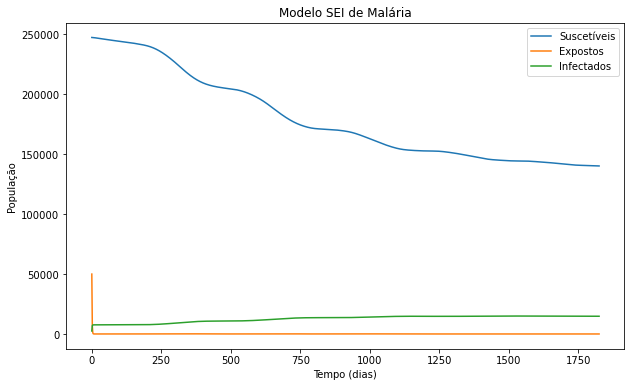

In [25]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model_plot_rates, [0, 1825], [N, 0, 0, S_M0, E_M0, I_M0, 0, 0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M, a_values, b3_values, tau_M_values = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

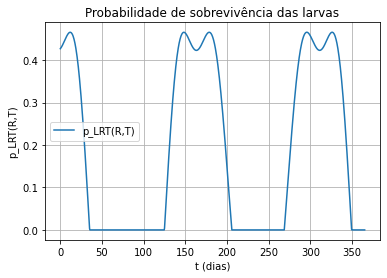

In [26]:
def p_LT(t):
        return np.exp(-(c1 * T(t) + c2))
    
def p_LR(t):
        return (4*p_ML/R_L**2) * R(t) * (max(1e-5,R_L - R(t)))
    
def p_LRT(t):
        return p_LR(R(t))*p_LT(T(t))

# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
larvae_survival = [p_LRT(t) for t in t_values]

# Plotando
plt.plot(t_values, larvae_survival, label='p_LRT(R,T)')
plt.title('Probabilidade de sobrevivência das larvas')
plt.xlabel('t (dias)')
plt.ylabel('p_LRT(R,T)')
plt.legend()
plt.grid(True)
plt.show()

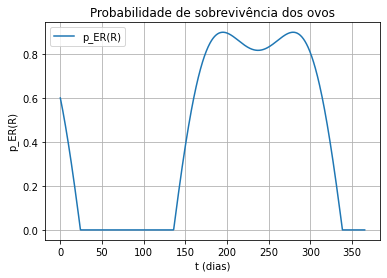

In [27]:
def p_ER(t):
        return (4*p_ME/R_L**2) * R(t) * (max(1e-5,R_L - R(t)))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
eggs_survival = [p_ER(t) for t in t_values]

# Plotando
plt.plot(t_values, eggs_survival, label='p_ER(R)')
plt.title('Probabilidade de sobrevivência dos ovos')
plt.xlabel('t (dias)')
plt.ylabel('p_ER(R)')
plt.legend()
plt.grid(True)
plt.show()    

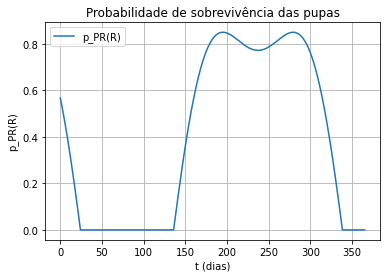

In [28]:
def p_PR(t):
        return (4*p_MP/R_L**2) * R(t) * (max(1e-5,R_L - R(t)))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
pupae_survival = [p_PR(t) for t in t_values]

# Plotando
plt.plot(t_values, pupae_survival, label='p_PR(R)')
plt.title('Probabilidade de sobrevivência das pupas')
plt.xlabel('t (dias)')
plt.ylabel('p_PR(R)')
plt.legend()
plt.grid(True)
plt.show()        

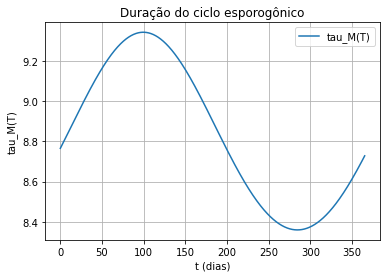

In [29]:
def sporogonic_cycle_duration(t):
        return DD/(max(1e-5, T(t)-Tmin))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
sporogonic_days = [sporogonic_cycle_duration(t) for t in t_values]

# Plotando
plt.plot(t_values, sporogonic_days, label='tau_M(T)')
plt.title('Duração do ciclo esporogônico')
plt.xlabel('t (dias)')
plt.ylabel('tau_M(T)')
plt.legend()
plt.grid(True)
plt.show()

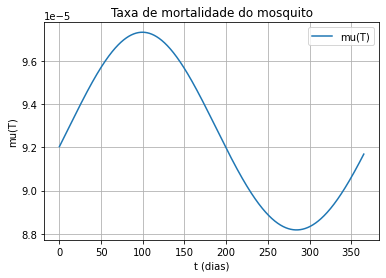

In [30]:
def mortality_rate(t):
        return n(-log(daily_survival_rate(t)))
   
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
mortality_values = [mortality_rate(t) for t in t_values]

# Plotando
plt.plot(t_values, mortality_values, label='mu(T)')
plt.title('Taxa de mortalidade do mosquito')
plt.xlabel('t (dias)')
plt.ylabel('mu(T)')
plt.legend()
plt.grid(True)
plt.show()    

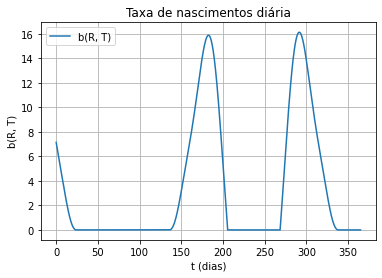

In [31]:
def birth_rate(t):
        return B_E * p_ER(t) * p_LRT(t) * p_PR(t) / (tau_E + larvae_development_rate(t) + tau_P)
   
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
birth_values = [birth_rate(t) for t in t_values]

# Plotando
plt.plot(t_values, birth_values, label='b(R, T)')
plt.title('Taxa de nascimentos diária')
plt.xlabel('t (dias)')
plt.ylabel('b(R, T)')
plt.legend()
plt.grid(True)
plt.show()    

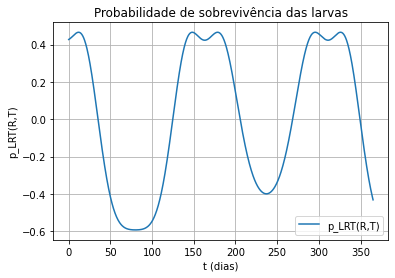

In [32]:
def p_LT_teste(t):
        return np.exp(-(c1 * T(t) + c2))
    
def p_LR_teste(t):
        return (4*p_ML/R_L**2) * R(t) * (R_L - R(t))
    
def p_LRT_teste(t):
        return p_LR_teste(R(t))*p_LT_teste(T(t))

# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
larvae_survival = [p_LRT_teste(t) for t in t_values]

# Plotando
plt.plot(t_values, larvae_survival, label='p_LRT(R,T)')
plt.title('Probabilidade de sobrevivência das larvas')
plt.xlabel('t (dias)')
plt.ylabel('p_LRT(R,T)')
plt.legend()
plt.grid(True)
plt.show()

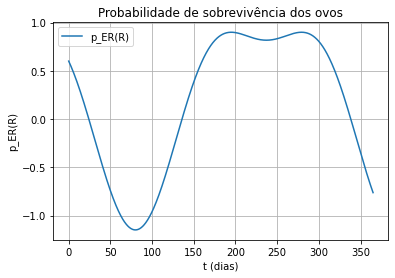

In [33]:
def p_ER_teste(t):
        return (4*p_ME/R_L**2) * R(t) * (R_L - R(t))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
eggs_survival = [p_ER_teste(t) for t in t_values]

# Plotando
plt.plot(t_values, eggs_survival, label='p_ER(R)')
plt.title('Probabilidade de sobrevivência dos ovos')
plt.xlabel('t (dias)')
plt.ylabel('p_ER(R)')
plt.legend()
plt.grid(True)
plt.show()    

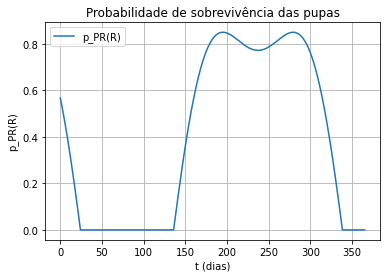

In [34]:
def p_PR_teste(t):
        return (4*p_MP/R_L**2) * R(t) * (R_L - R(t))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
pupae_survival = [p_PR(t) for t in t_values]

# Plotando
plt.plot(t_values, pupae_survival, label='p_PR(R)')
plt.title('Probabilidade de sobrevivência das pupas')
plt.xlabel('t (dias)')
plt.ylabel('p_PR(R)')
plt.legend()
plt.grid(True)
plt.show()  

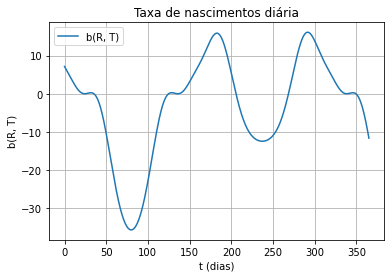

In [35]:
def birth_rate_teste(t):
        return B_E * p_ER_teste(t) * p_LRT_teste(t) * p_PR_teste(t) / (tau_E + larvae_development_rate(t) + tau_P)
   
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
birth_values = [birth_rate_teste(t) for t in t_values]

# Plotando
plt.plot(t_values, birth_values, label='b(R, T)')
plt.title('Taxa de nascimentos diária')
plt.xlabel('t (dias)')
plt.ylabel('b(R, T)')
plt.legend()
plt.grid(True)
plt.show()  

In [36]:
R_L = 400

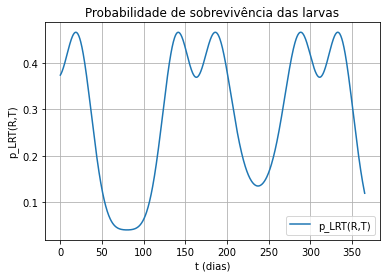

In [37]:
def p_LT_teste(t):
        return np.exp(-(c1 * T(t) + c2))
    
def p_LR_teste(t):
        return (4*p_ML/R_L**2) * R(t) * (R_L - R(t))
    
def p_LRT_teste(t):
        return p_LR_teste(R(t))*p_LT_teste(T(t))

# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
larvae_survival = [p_LRT_teste(t) for t in t_values]

# Plotando
plt.plot(t_values, larvae_survival, label='p_LRT(R,T)')
plt.title('Probabilidade de sobrevivência das larvas')
plt.xlabel('t (dias)')
plt.ylabel('p_LRT(R,T)')
plt.legend()
plt.grid(True)
plt.show()

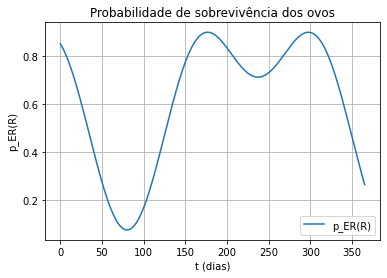

In [38]:
def p_ER_teste(t):
        return (4*p_ME/R_L**2) * R(t) * (R_L - R(t))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
eggs_survival = [p_ER_teste(t) for t in t_values]

# Plotando
plt.plot(t_values, eggs_survival, label='p_ER(R)')
plt.title('Probabilidade de sobrevivência dos ovos')
plt.xlabel('t (dias)')
plt.ylabel('p_ER(R)')
plt.legend()
plt.grid(True)
plt.show()    

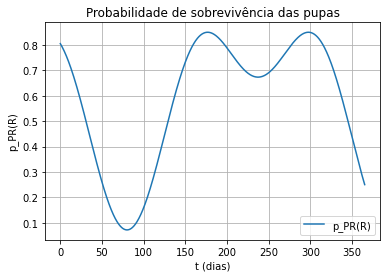

In [39]:
def p_PR_teste(t):
        return (4*p_MP/R_L**2) * R(t) * (R_L - R(t))
    
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
pupae_survival = [p_PR(t) for t in t_values]

# Plotando
plt.plot(t_values, pupae_survival, label='p_PR(R)')
plt.title('Probabilidade de sobrevivência das pupas')
plt.xlabel('t (dias)')
plt.ylabel('p_PR(R)')
plt.legend()
plt.grid(True)
plt.show()  

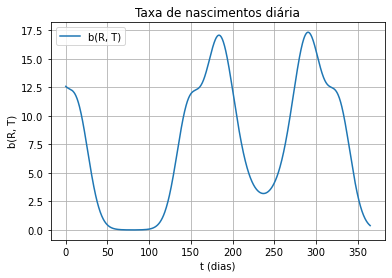

In [40]:
def birth_rate_teste(t):
        return B_E * p_ER_teste(t) * p_LRT_teste(t) * p_PR_teste(t) / (tau_E + larvae_development_rate(t) + tau_P)
   
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
birth_values = [birth_rate_teste(t) for t in t_values]

# Plotando
plt.plot(t_values, birth_values, label='b(R, T)')
plt.title('Taxa de nascimentos diária')
plt.xlabel('t (dias)')
plt.ylabel('b(R, T)')
plt.legend()
plt.grid(True)
plt.show()  